Давайте вернёмся к данным выживаемости пациентов с лейкоцитарной лимфомой из видео про критерий знаков:

49,58,75,110,112,132,151,276,281,362∗

Измерено остаточное время жизни с момента начала наблюдения (в неделях); звёздочка обозначает цензурирование сверху — исследование длилось 7 лет, и остаточное время жизни одного пациента, который дожил до конца наблюдения, неизвестно.

Поскольку цензурировано только одно наблюдение, для проверки гипотезы H0:medX=200 на этих данных можно использовать критерий знаковых рангов — можно считать, что время дожития последнего пациента в точности равно 362, на ранг этого наблюдения это никак не повлияет.

Критерием знаковых рангов проверьте эту гипотезу против двусторонней альтернативы, введите достигаемый уровень значимости, округлённый до четырёх знаков после десятичной точки.

In [65]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint


In [66]:
data = np.array([49,58,75,110,112,132,151,276,281,362])

H0:medX=200
H1:medX<>200

In [67]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


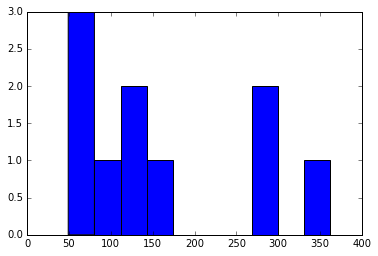

In [68]:
pylab.hist(data)
pylab.show()

In [72]:
m0 = 200
print stats.wilcoxon(data - m0)

WilcoxonResult(statistic=17.0, pvalue=0.28450269791120752)


В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

22,22,15,13,19,19,18,20,21,13,13,15,

и в 9 лесах, где идёт вырубка:

17,18,18,15,12,4,14,15,10.

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах. Используйте ранговый критерий. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [73]:
forest_cutting = np.array([17,18,18,15,12,4,14,15,10])
forest_not_cutting = np.array([22,22,15,13,19,19,18,20,21,13,13,15])

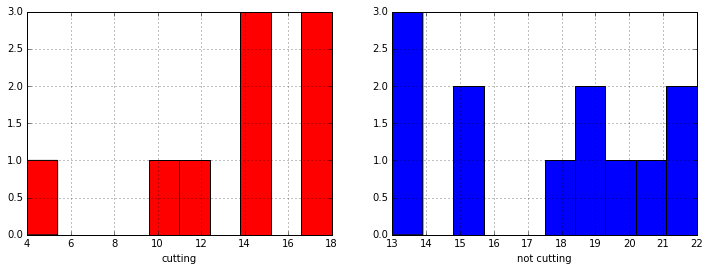

In [74]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(forest_cutting, color = 'r')
pylab.xlabel('cutting')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(forest_not_cutting, color = 'b')
pylab.xlabel('not cutting')

pylab.show()

In [75]:
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(forest_cutting)

95% confidence interval for the mean: [10.726721, 16.606613]


In [76]:
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(forest_not_cutting)

95% confidence interval for the mean: [15.503261, 19.496739]


In [78]:
stats.mannwhitneyu(forest_not_cutting, forest_cutting, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.029004992720873729)

In [79]:
challenger = pd.read_csv('challenger.txt', sep = '\t', header = 0)

In [80]:
challenger.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [81]:
challenger.shape

(23, 3)

In [82]:
challenger_incident = challenger[challenger['Incident'] == 1]
challenger_non_incident = challenger[challenger['Incident'] == 0]

In [83]:
print 'incident - ', challenger_incident.shape, 'non incident', challenger_non_incident.shape

incident -  (7, 3) non incident (16, 3)


С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

Чтобы получить в точности такой же доверительный интервал, как у нас:

    установите random seed = 0 перед первым вызовом функции get_bootstrap_samples, один раз
    сделайте по 1000 псевдовыборок из каждой выборки.

In [94]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [95]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [96]:
incident = challenger_incident.Temperature.values
non_incident = challenger_non_incident.Temperature.values

In [97]:
np.random.seed(0)
incident_mean_scores = map(np.mean, get_bootstrap_samples(incident, 1000))
non_incident_mean_scores = map(np.mean, get_bootstrap_samples(non_incident, 1000))

In [98]:
mean_scores = zip(map(np.mean, non_incident_mean_scores), map(np.mean,incident_mean_scores))

In [99]:
delta_mean_scores = map(lambda x: x[1] - x[0], mean_scores)

In [101]:
print "95% confidence interval for the difference between median repair times:",  stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between median repair times: [-8.06457589 -1.45040179]


In [102]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [103]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [104]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

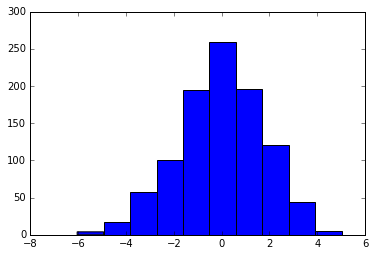

In [105]:
pylab.hist(permutation_zero_dist_ind(incident, non_incident, max_combinations = 1000))
pylab.show()

In [106]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [107]:
print "p-value: %f" % permutation_test(incident, non_incident, max_permutations = 10000)

p-value: 0.005700


2,3,4,6